<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/AI_art_human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!rm *.csv
#!rm *.png
#!rm -r data

In [2]:
import warnings
warnings.filterwarnings('ignore')

!pip install lightgbm scikit-learn opencv-python matplotlib seaborn kaggle scipy umap-learn -q

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

KAGGLE_JSON = "/content/drive/MyDrive/kaggle.json"
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp "{KAGGLE_JSON}" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!mkdir -p ./data/art_dataset
!kaggle datasets download -d kausthubkannan/ai-and-human-art-classification -p ./data/art_dataset
!unzip -q -n ./data/art_dataset/ai-and-human-art-classification.zip -d ./data/art_dataset/

# ==================== IMPORTS ====================
import pathlib, random, time, gc, copy
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            roc_curve, precision_recall_fscore_support, accuracy_score,
                            precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 9
sns.set_palette("colorblind")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/ai-and-human-art-classification
License(s): DbCL-1.0
100% 2.20G/2.21G [00:13<00:00, 213MB/s]
100% 2.21G/2.21G [00:14<00:00, 169MB/s]


In [3]:
# ==================== CONFIGURATION ====================
DATASET_LIMIT = 10000  # Per class - sufficient for publication
BATCH_SIZE = 16
NUM_WORKERS = 0
NUM_EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# ==================== TIMING SYSTEM ====================
class Timer:
    def __init__(self, name):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.time()
        print(f"\n⏱️  {self.name}...")
        return self

    def __exit__(self, *args):
        elapsed = time.time() - self.start
        print(f"✅ {self.name}: {elapsed:.2f}s ({elapsed/60:.2f}min)")
        return elapsed

timings = {}

# ==================== DATA LOADING ====================
with Timer("Data Loading") as t:
    DATA_ROOT = pathlib.Path("./data/art_dataset/ai_art_classification/train")
    HUMAN_PATH = DATA_ROOT / "NON_AI_GENERATED"
    AI_PATH = DATA_ROOT / "AI_GENERATED"

    from itertools import islice
    human_files = list(islice(HUMAN_PATH.glob("*.jpg"), DATASET_LIMIT))
    ai_files = list(islice(AI_PATH.glob("*.jpg"), DATASET_LIMIT))
    all_files = human_files + ai_files
    labels = [0]*len(human_files) + [1]*len(ai_files)

    train_files, temp_files, train_labels, temp_labels = train_test_split(
        all_files, labels, test_size=0.3, stratify=labels, random_state=SEED
    )
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
    )

    print(f"📊 Dataset: {len(all_files)} total | Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

timings['data_loading'] = t.__exit__()


🖥️  Device: cuda

⏱️  Data Loading...
📊 Dataset: 18288 total | Train: 12801 | Val: 2743 | Test: 2744
✅ Data Loading: 0.23s (0.00min)
✅ Data Loading: 0.23s (0.00min)


In [4]:

# ==================== HANDCRAFTED FEATURES ====================
def extract_features(img_path):
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))

        features = []

        # Color stats (15 features)
        for ch in range(3):
            c = img[:,:,ch]
            features.extend([c.mean(), c.std(), np.median(c),
                           stats.skew(c.flatten()), stats.kurtosis(c.flatten())])

        # Texture (3 features)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist / (hist.sum() + 1e-7)
        entropy = -np.sum(hist * np.log2(hist + 1e-7))
        features.extend([entropy, gray.std(), cv2.Laplacian(gray, cv2.CV_64F).var()])

        # NOVEL: Frequency domain (3 features)
        dct = cv2.dct(np.float32(gray))
        h, w = dct.shape
        high_freq = np.abs(dct[h//2:, w//2:]).sum() / (h * w)
        low_freq = np.abs(dct[:h//2, :w//2]).sum() / (h * w)
        freq_ratio = high_freq / (low_freq + 1e-7)
        features.extend([high_freq, low_freq, freq_ratio])

        # Edges (2 features)
        edges = cv2.Canny(gray, 50, 150)
        features.extend([edges.mean(), edges.sum() / (h * w)])

        return np.array(features, dtype=np.float32)
    except:
        return None

feature_names = [
    'R_mean', 'R_std', 'R_med', 'R_skew', 'R_kurt',
    'G_mean', 'G_std', 'G_med', 'G_skew', 'G_kurt',
    'B_mean', 'B_std', 'B_med', 'B_skew', 'B_kurt',
    'Entropy', 'Contrast', 'Laplacian',
    'High_freq', 'Low_freq', 'Freq_ratio', 'Edge_density', 'Edge_smooth'
]

with Timer("Handcrafted Feature Extraction") as t:
    def extract_batch(files):
        return np.array([f for f in [extract_features(fp) for fp in tqdm(files, leave=False, desc="Extracting")] if f is not None])

    X_train_hand = extract_batch(train_files)
    X_val_hand = extract_batch(val_files)
    X_test_hand = extract_batch(test_files)

    scaler = StandardScaler()
    X_train_hand = scaler.fit_transform(X_train_hand)
    X_val_hand = scaler.transform(X_val_hand)
    X_test_hand = scaler.transform(X_test_hand)

    print(f"📐 Handcrafted features: {X_train_hand.shape}")
    gc.collect()

timings['handcrafted_extraction'] = t.__exit__()

# ==================== CNN FEATURES ====================
with Timer("CNN Feature Extraction") as t:
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    feature_net = models.mobilenet_v2(weights='IMAGENET1K_V1')
    feature_net.classifier = nn.Identity()
    feature_net.eval().to(device)

    def extract_cnn_batch(files, batch_size=16):
        all_feats = []
        with torch.no_grad():
            for i in tqdm(range(0, len(files), batch_size), leave=False, desc="CNN features"):
                batch = files[i:i+batch_size]
                tensors = []
                for f in batch:
                    try:
                        tensors.append(transform(Image.open(f).convert("RGB")))
                    except:
                        continue
                if tensors:
                    batch_t = torch.stack(tensors).to(device)
                    all_feats.append(feature_net(batch_t).cpu().numpy())
                    del batch_t
                if i % 100 == 0:
                    torch.cuda.empty_cache()
        return np.vstack(all_feats).astype(np.float32)

    X_train_cnn = extract_cnn_batch(train_files)
    X_val_cnn = extract_cnn_batch(val_files)
    X_test_cnn = extract_cnn_batch(test_files)

    del feature_net
    gc.collect()
    torch.cuda.empty_cache()

    print(f"🧠 CNN features: {X_train_cnn.shape}")

timings['cnn_extraction'] = t.__exit__()

# ==================== METHOD 1: HANDCRAFTED + RF ====================
print("\n" + "="*70)
print("METHOD 1: Handcrafted Features + Random Forest")
print("="*70)

with Timer("Method 1 Training") as t:
    rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf_model.fit(X_train_hand, train_labels)

timings['method1_train'] = t.__exit__()

with Timer("Method 1 Inference") as t:
    pred_rf = rf_model.predict(X_test_hand)
    prob_rf = rf_model.predict_proba(X_test_hand)[:, 1]

timings['method1_inference'] = t.__exit__()

p, r, f1_rf, _ = precision_recall_fscore_support(test_labels, pred_rf, average='binary')
acc_rf = accuracy_score(test_labels, pred_rf)
roc_rf = roc_auc_score(test_labels, prob_rf)
print(f"📊 F1={f1_rf:.4f} | Acc={acc_rf:.4f} | ROC-AUC={roc_rf:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# ==================== METHOD 2: ATTENTION FUSION ====================
print("\n" + "="*70)
print("METHOD 2: Attention Fusion (NOVEL)")
print("="*70)

class AttentionFusion(nn.Module):
    def __init__(self, hand_dim, cnn_dim, hidden=64):
        super().__init__()
        self.hand_proj = nn.Linear(hand_dim, hidden)
        self.cnn_proj = nn.Linear(cnn_dim, hidden)
        self.attention = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
            nn.Softmax(dim=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )

    def forward(self, hand, cnn, return_hidden=False):
        h = F.relu(self.hand_proj(hand))
        c = F.relu(self.cnn_proj(cnn))
        attn = self.attention(torch.cat([h, c], 1))
        fused = attn[:, 0:1] * h + attn[:, 1:2] * c
        out = self.classifier(fused)
        if return_hidden:
            return out, attn, fused
        return out, attn

class FusionDataset(Dataset):
    def __init__(self, hand, cnn, labels):
        self.hand = torch.FloatTensor(hand)
        self.cnn = torch.FloatTensor(cnn)
        self.labels = torch.LongTensor(labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        return self.hand[i], self.cnn[i], self.labels[i]

train_ds = FusionDataset(X_train_hand, X_train_cnn, train_labels)
val_ds = FusionDataset(X_val_hand, X_val_cnn, val_labels)
test_ds = FusionDataset(X_test_hand, X_test_cnn, test_labels)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader_fusion = DataLoader(test_ds, batch_size=64, shuffle=False)

fusion_model = AttentionFusion(X_train_hand.shape[1], X_train_cnn.shape[1]).to(device)
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=1e-3, weight_decay=1e-4)

with Timer("Method 2 Training") as t:
    best_f1 = 0
    for epoch in range(1, 6):
        fusion_model.train()
        for hand, cnn, labels in train_loader:
            hand, cnn, labels = hand.to(device), cnn.to(device), labels.to(device)
            optimizer.zero_grad()
            out, _ = fusion_model(hand, cnn)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()

        fusion_model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for hand, cnn, labels in val_loader:
                hand, cnn = hand.to(device), cnn.to(device)
                out, _ = fusion_model(hand, cnn)
                preds.append(out.argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds, targets = np.concatenate(preds), np.concatenate(targets)
        f1 = precision_recall_fscore_support(targets, preds, average='binary')[2]
        print(f"  Epoch {epoch}: Val F1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state = copy.deepcopy(fusion_model.state_dict())

    fusion_model.load_state_dict(best_state)

timings['method2_train'] = t.__exit__()

with Timer("Method 2 Inference") as t:
    fusion_model.eval()
    pred_fusion, prob_fusion, attn_weights, fusion_features = [], [], [], []
    with torch.no_grad():
        for hand, cnn, labels in test_loader_fusion:
            hand, cnn = hand.to(device), cnn.to(device)
            out, attn, fused = fusion_model(hand, cnn, return_hidden=True)
            prob_fusion.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_fusion.append(out.argmax(1).cpu().numpy())
            attn_weights.append(attn.cpu().numpy())
            fusion_features.append(fused.cpu().numpy())

    pred_fusion = np.concatenate(pred_fusion)
    prob_fusion = np.concatenate(prob_fusion)
    attn_weights = np.concatenate(attn_weights)
    fusion_features = np.concatenate(fusion_features)

timings['method2_inference'] = t.__exit__()

p, r, f1_fusion, _ = precision_recall_fscore_support(test_labels, pred_fusion, average='binary')
acc_fusion = accuracy_score(test_labels, pred_fusion)
roc_fusion = roc_auc_score(test_labels, prob_fusion)
print(f"📊 F1={f1_fusion:.4f} | Acc={acc_fusion:.4f} | ROC-AUC={roc_fusion:.4f}")

del fusion_model
gc.collect()
torch.cuda.empty_cache()

# ==================== METHOD 3: RESNET50 ====================
print("\n" + "="*70)
print("METHOD 3: ResNet50")
print("="*70)

class ImageDataset(Dataset):
    def __init__(self, files, labels, transform):
        self.files = files
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert('RGB')
        return self.transform(img), self.labels[i]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds_img = ImageDataset(train_files, train_labels, transform_train)
val_ds_img = ImageDataset(val_files, val_labels, transform_test)
test_ds_img = ImageDataset(test_files, test_labels, transform_test)

train_loader_img = DataLoader(train_ds_img, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_img = DataLoader(val_ds_img, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_resnet = DataLoader(test_ds_img, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

resnet = models.resnet50(weights='IMAGENET1K_V2')
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.to(device)
optimizer_resnet = torch.optim.AdamW(resnet.parameters(), lr=1e-4, weight_decay=1e-4)

with Timer("Method 3 Training") as t:
    best_f1 = 0
    for epoch in range(1, NUM_EPOCHS + 1):
        resnet.train()
        for imgs, labels in tqdm(train_loader_img, desc=f"Epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_resnet.zero_grad()
            out = resnet(imgs)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer_resnet.step()

        resnet.eval()
        preds, targets = [], []
        with torch.no_grad():
            for imgs, labels in val_loader_img:
                imgs = imgs.to(device)
                preds.append(resnet(imgs).argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds, targets = np.concatenate(preds), np.concatenate(targets)
        f1 = precision_recall_fscore_support(targets, preds, average='binary')[2]
        print(f"  Epoch {epoch}: Val F1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state_resnet = copy.deepcopy(resnet.state_dict())

        torch.cuda.empty_cache()

    resnet.load_state_dict(best_state_resnet)

timings['method3_train'] = t.__exit__()

# Extract ResNet features for visualization
resnet_penultimate = nn.Sequential(*list(resnet.children())[:-1])
resnet_penultimate.eval()

with Timer("Method 3 Inference") as t:
    pred_resnet, prob_resnet, resnet_features = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader_resnet:
            imgs = imgs.to(device)
            out = resnet(imgs)
            feats = resnet_penultimate(imgs).squeeze()
            if feats.dim() == 1:  # Handle single sample case
                feats = feats.unsqueeze(0)
            prob_resnet.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_resnet.append(out.argmax(1).cpu().numpy())
            resnet_features.append(feats.cpu().numpy())

    pred_resnet = np.concatenate(pred_resnet)
    prob_resnet = np.concatenate(prob_resnet)
    resnet_features = np.vstack(resnet_features)

timings['method3_inference'] = t.__exit__()

p, r, f1_resnet, _ = precision_recall_fscore_support(test_labels, pred_resnet, average='binary')
acc_resnet = accuracy_score(test_labels, pred_resnet)
roc_resnet = roc_auc_score(test_labels, prob_resnet)
print(f"📊 F1={f1_resnet:.4f} | Acc={acc_resnet:.4f} | ROC-AUC={roc_resnet:.4f}")

del resnet, resnet_penultimate
gc.collect()
torch.cuda.empty_cache()



⏱️  Handcrafted Feature Extraction...


Extracting:   0%|          | 0/12801 [00:00<?, ?it/s]

Extracting:   0%|          | 0/2743 [00:00<?, ?it/s]

Extracting:   0%|          | 0/2744 [00:00<?, ?it/s]

📐 Handcrafted features: (12801, 23)
✅ Handcrafted Feature Extraction: 187.55s (3.13min)
✅ Handcrafted Feature Extraction: 187.55s (3.13min)

⏱️  CNN Feature Extraction...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 98.3MB/s]


CNN features:   0%|          | 0/801 [00:00<?, ?it/s]

CNN features:   0%|          | 0/172 [00:00<?, ?it/s]

CNN features:   0%|          | 0/172 [00:00<?, ?it/s]

🧠 CNN features: (12801, 1280)
✅ CNN Feature Extraction: 82.63s (1.38min)
✅ CNN Feature Extraction: 82.63s (1.38min)

METHOD 1: Handcrafted Features + Random Forest

⏱️  Method 1 Training...
✅ Method 1 Training: 4.78s (0.08min)
✅ Method 1 Training: 4.78s (0.08min)

⏱️  Method 1 Inference...
✅ Method 1 Inference: 0.10s (0.00min)
✅ Method 1 Inference: 0.10s (0.00min)
📊 F1=0.8077 | Acc=0.7883 | ROC-AUC=0.8604

🔍 Top 10 Most Important Features:
     Feature  Importance
    Low_freq    0.074114
       G_std    0.066157
 Edge_smooth    0.063221
Edge_density    0.062008
       B_std    0.055786
      R_mean    0.052560
      G_mean    0.050434
       R_std    0.049685
    Contrast    0.048299
     Entropy    0.047432

METHOD 2: Attention Fusion (NOVEL)

⏱️  Method 2 Training...
  Epoch 1: Val F1=0.8788
  Epoch 2: Val F1=0.8873
  Epoch 3: Val F1=0.8963
  Epoch 4: Val F1=0.8958
  Epoch 5: Val F1=0.9001
✅ Method 2 Training: 3.93s (0.07min)
✅ Method 2 Training: 3.93s (0.07min)

⏱️  Method 2 Infere

100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]



⏱️  Method 3 Training...


Epoch 1:   0%|          | 0/801 [00:00<?, ?it/s]

  Epoch 1: Val F1=0.9183


Epoch 2:   0%|          | 0/801 [00:00<?, ?it/s]

  Epoch 2: Val F1=0.9290


Epoch 3:   0%|          | 0/801 [00:00<?, ?it/s]

  Epoch 3: Val F1=0.9284


Epoch 4:   0%|          | 0/801 [00:00<?, ?it/s]

  Epoch 4: Val F1=0.9287


Epoch 5:   0%|          | 0/801 [00:00<?, ?it/s]

  Epoch 5: Val F1=0.9265
✅ Method 3 Training: 407.05s (6.78min)
✅ Method 3 Training: 407.05s (6.78min)

⏱️  Method 3 Inference...
✅ Method 3 Inference: 15.09s (0.25min)
✅ Method 3 Inference: 15.09s (0.25min)
📊 F1=0.9434 | Acc=0.9384 | ROC-AUC=0.9839


In [5]:
# ==================== METHOD 4: VISION TRANSFORMER ====================
print("\n" + "="*70)
print("METHOD 4: Vision Transformer (ViT-B/16)")
print("="*70)

# Create FRESH datasets and dataloaders for ViT with 224x224 images
transform_train_vit = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Changed from 128 to 224 for ViT
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test_vit = transforms.Compose([
    transforms.Resize((224, 224)),  # Changed from 128 to 224 for ViT
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds_img_vit = ImageDataset(train_files, train_labels, transform_train_vit)
val_ds_img_vit = ImageDataset(val_files, val_labels, transform_test_vit)
test_ds_img_vit = ImageDataset(test_files, test_labels, transform_test_vit)

train_loader_vit = DataLoader(train_ds_img_vit, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_vit = DataLoader(val_ds_img_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_vit = DataLoader(test_ds_img_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

vit = models.vit_b_16(weights='IMAGENET1K_V1')
vit.heads.head = nn.Linear(vit.heads.head.in_features, 2)
vit = vit.to(device)
optimizer_vit = torch.optim.AdamW(vit.parameters(), lr=1e-4, weight_decay=1e-4)

with Timer("Method 4 Training") as t:
    best_f1 = 0
    for epoch in range(1, NUM_EPOCHS + 1):
        vit.train()
        for imgs, labels in tqdm(train_loader_vit, desc=f"Epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_vit.zero_grad()
            out = vit(imgs)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer_vit.step()

        vit.eval()
        preds, targets = [], []
        with torch.no_grad():
            for imgs, labels in val_loader_vit:
                imgs = imgs.to(device)
                preds.append(vit(imgs).argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds, targets = np.concatenate(preds), np.concatenate(targets)
        f1 = precision_recall_fscore_support(targets, preds, average='binary')[2]
        print(f"  Epoch {epoch}: Val F1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state_vit = copy.deepcopy(vit.state_dict())

        torch.cuda.empty_cache()

    vit.load_state_dict(best_state_vit)

timings['method4_train'] = t.__exit__()

with Timer("Method 4 Inference") as t:
    pred_vit, prob_vit = [], []
    with torch.no_grad():
        for imgs, labels in test_loader_vit:
            imgs = imgs.to(device)
            out = vit(imgs)
            prob_vit.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_vit.append(out.argmax(1).cpu().numpy())

    pred_vit = np.concatenate(pred_vit)
    prob_vit = np.concatenate(prob_vit)

timings['method4_inference'] = t.__exit__()

p, r, f1_vit, _ = precision_recall_fscore_support(test_labels, pred_vit, average='binary')
acc_vit = accuracy_score(test_labels, pred_vit)
roc_vit = roc_auc_score(test_labels, prob_vit)
print(f"📊 F1={f1_vit:.4f} | Acc={acc_vit:.4f} | ROC-AUC={roc_vit:.4f}")

del vit
gc.collect()
torch.cuda.empty_cache()


METHOD 4: Vision Transformer (ViT-B/16)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 179MB/s]



⏱️  Method 4 Training...


Epoch 1:   0%|          | 0/801 [00:00<?, ?it/s]

  Epoch 1: Val F1=0.8731


Epoch 2:   0%|          | 0/801 [00:00<?, ?it/s]

  Epoch 2: Val F1=0.8824


Epoch 3:   0%|          | 0/801 [00:00<?, ?it/s]

✅ Method 4 Training: 1090.13s (18.17min)
✅ Method 4 Training: 1090.13s (18.17min)

⏱️  Method 4 Inference...
✅ Method 4 Inference: 12.47s (0.21min)
✅ Method 4 Inference: 12.47s (0.21min)


ValueError: Found input variables with inconsistent numbers of samples: [2744, 46]

In [15]:
# ======================================================================
# METHOD 3b (FIXED & COMPLETE): ResNet50 Penultimate + Handcrafted Fusion
# ======================================================================

print("\n" + "="*70)
print("METHOD 3b (FIXED): ResNet50 + Handcrafted Attention Fusion")
print("="*70)

# ============================================================
# 1. Ensure ResNet50 Exists
# ============================================================
try:
    resnet
    print("✓ Using existing ResNet model")
except NameError:
    print("⚠ ResNet not found, recreating it...")
    resnet = models.resnet50(weights="IMAGENET1K_V2").to(device)
    resnet.eval()

# Penultimate extractor (everything minus final FC)
resnet_penultimate = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet_penultimate.eval()


# ============================================================
# 2. Extract ResNet Features Matching EXACT Same Order as Handcrafted
# ============================================================

def extract_features_from_files(file_list, transform, model, device):
    feats = []
    for f in tqdm(file_list, desc="Extracting ResNet Penultimate (ordered)", leave=False):
        img = Image.open(f).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            vec = model(img).view(1, -1)
        feats.append(vec.cpu().numpy())
    return np.vstack(feats).astype(np.float32)


with Timer("ResNet50 Penultimate Feature Extraction") as t:
    X_train_resnet_pen = extract_features_from_files(
        train_files, resnet_transform, resnet_penultimate, device
    )
    X_val_resnet_pen = extract_features_from_files(
        val_files, resnet_transform, resnet_penultimate, device
    )
    X_test_resnet_pen = extract_features_from_files(
        test_files, resnet_transform, resnet_penultimate, device
    )

timings["resnet_penultimate_extraction"] = t.__exit__()

print("Penultimate shapes now aligned with handcrafted features:")
print("Train:", X_train_resnet_pen.shape)
print("Val:  ", X_val_resnet_pen.shape)
print("Test: ", X_test_resnet_pen.shape)


# ============================================================
# 3. Fusion Dataset
# ============================================================

class FusionDatasetResNet(Dataset):
    def __init__(self, Xh, Xc, y):
        self.Xh = torch.FloatTensor(Xh)
        self.Xc = torch.FloatTensor(Xc)
        self.y  = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.Xh[idx], self.Xc[idx], self.y[idx]


train_ds_r = FusionDatasetResNet(X_train_hand, X_train_resnet_pen, train_labels)
val_ds_r   = FusionDatasetResNet(X_val_hand,   X_val_resnet_pen,   val_labels)
test_ds_r  = FusionDatasetResNet(X_test_hand,  X_test_resnet_pen,  test_labels)

train_loader_r = DataLoader(train_ds_r, batch_size=64, shuffle=True)
val_loader_r   = DataLoader(val_ds_r,   batch_size=64, shuffle=False)
test_loader_r  = DataLoader(test_ds_r,  batch_size=64, shuffle=False)


# ============================================================
# 4. Define Fusion Model (your same AttentionFusion)
# ============================================================

fusion_resnet = AttentionFusion(
    hand_dim=X_train_hand.shape[1],
    cnn_dim=2048,
    hidden=64
).to(device)

optimizer_fusion_r = torch.optim.AdamW(fusion_resnet.parameters(), lr=1e-3)


# ============================================================
# 5. Train Fusion Model with Validation F1 Model Selection
# ============================================================

best_state_r = copy.deepcopy(fusion_resnet.state_dict())
best_f1 = 0

with Timer("Method 3b Training") as t:
    for epoch in range(1, NUM_EPOCHS+1):

        # Training
        fusion_resnet.train()
        for hand, resf, labels in train_loader_r:
            hand, resf, labels = hand.to(device), resf.to(device), labels.to(device)

            optimizer_fusion_r.zero_grad()
            out, _ = fusion_resnet(hand, resf)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer_fusion_r.step()

        # Validation F1
        fusion_resnet.eval()
        preds, targets = [], []
        with torch.no_grad():
            for hand, resf, labels in val_loader_r:
                hand, resf = hand.to(device), resf.to(device)
                out, _ = fusion_resnet(hand, resf)
                preds.append(out.argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds = np.concatenate(preds)
        targets = np.concatenate(targets)
        f1 = precision_recall_fscore_support(targets, preds, average="binary")[2]

        print(f"Epoch {epoch}: Val F1 = {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state_r = copy.deepcopy(fusion_resnet.state_dict())

fusion_resnet.load_state_dict(best_state_r)
timings["method3b_train"] = t.__exit__()


# ============================================================
# 6. Test Performance
# ============================================================

with Timer("Method 3b Inference") as t:
    preds, probs = [], []
    fusion_resnet.eval()
    with torch.no_grad():
        for hand, resf, _ in test_loader_r:
            hand, resf = hand.to(device), resf.to(device)
            out, _ = fusion_resnet(hand, resf)
            preds.append(out.argmax(1).cpu().numpy())
            probs.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())

timings["method3b_inference"] = t.__exit__()

preds = np.concatenate(preds)
probs = np.concatenate(probs)

p_r, r_r, f1_r, _ = precision_recall_fscore_support(test_labels, preds, average="binary")
acc_r = accuracy_score(test_labels, preds)
roc_r = roc_auc_score(test_labels, probs)

print("\n📊 FINAL RESNET-FUSION PERFORMANCE:")
print(f"F1       = {f1_r:.4f}")
print(f"Accuracy = {acc_r:.4f}")
print(f"ROC-AUC  = {roc_r:.4f}")


# ============================================================
# 7. Add to Results Table (Robust: Works for both names)
# ============================================================

# Detect the correct table reference
if "results_df" in globals():
    table_ref = results_df
elif "results_table" in globals():
    table_ref = results_table
else:
    # Create a new table if needed
    table_ref = pd.DataFrame(columns=[
        "Method", "F1", "Accuracy", "ROC-AUC",
        "Feature Extraction (s)", "Training (s)",
        "Inference (s)", "Total Pipeline (s)"
    ])
    results_table = table_ref

# Add row
table_ref.loc[len(table_ref)] = {
    "Method": "ResNet50 + Fusion",
    "F1": f1_r,
    "Accuracy": acc_r,
    "ROC-AUC": roc_r,
    "Feature Extraction (s)": timings["handcrafted_extraction"] + timings["resnet_penultimate_extraction"],
    "Training (s)": timings["method3b_train"],
    "Inference (s)": timings["method3b_inference"],
    "Total Pipeline (s)": timings["handcrafted_extraction"] + timings["resnet_penultimate_extraction"] + timings["method3b_train"],
}

print("\n✅ Added 'ResNet50 + Fusion' to results table.")



METHOD 3b (FIXED): ResNet50 + Handcrafted Attention Fusion
✓ Using existing ResNet model

⏱️  ResNet50 Penultimate Feature Extraction...
✅ ResNet50 Penultimate Feature Extraction: 0.00s (0.00min)
✅ ResNet50 Penultimate Feature Extraction: 0.00s (0.00min)
Penultimate shapes now aligned with handcrafted features:
Train: (12801, 2048)
Val:   (2743, 2048)
Test:  (2744, 2048)

⏱️  Method 3b Training...
Epoch 1: Val F1 = 0.7930
Epoch 2: Val F1 = 0.7966
Epoch 3: Val F1 = 0.7811
Epoch 4: Val F1 = 0.7879
Epoch 5: Val F1 = 0.7716
✅ Method 3b Training: 10.37s (0.17min)
✅ Method 3b Training: 10.38s (0.17min)

⏱️  Method 3b Inference...
✅ Method 3b Inference: 0.17s (0.00min)
✅ Method 3b Inference: 0.17s (0.00min)

📊 FINAL RESNET-FUSION PERFORMANCE:
F1       = 0.7972
Accuracy = 0.7711
ROC-AUC  = 0.8555

✅ Added 'ResNet50 + Fusion' to results table.


In [ ]:
# ======================================================================
# METHOD 3c: ViT-B/16 + Handcrafted Attention Fusion (Frozen Features)
# ======================================================================

print("\n" + "="*70)
print("METHOD 3c: ViT-B/16 + Handcrafted Attention Fusion (Frozen)")
print("="*70)

from torchvision.models import vit_b_16, ViT_B_16_Weights

# ============================================================
# 1. Load ViT-B/16 (frozen)
# ============================================================

try:
    vit
    print("✓ Using existing ViT-B/16 model")
except NameError:
    print("⚠ ViT not found — loading ViT-B/16 backbone...")
    vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1).to(device)
    vit.eval()

# Correct ViT penultimate extractor (returns CLS token)
class ViT_Penultimate(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model
        # Remove classification head so output = CLS embedding
        self.vit.heads = nn.Identity()

    def forward(self, x):
        # vit returns CLS embedding when heads = Identity
        return self.vit(x)

vit_penultimate = ViT_Penultimate(vit).to(device)
vit_penultimate.eval()

# Use official ViT transforms (224x224, normalization)
vit_transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()


# ============================================================
# 2. Extract ViT Penultimate Features (ordered)
# ============================================================

def extract_vit_features(file_list, transform, model, device):
    feats = []
    for f in tqdm(file_list, desc="Extracting ViT Penultimate (ordered)", leave=False):
        img = Image.open(f).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            cls = model(img).cpu().numpy()   # shape: (1, 768)
        feats.append(cls)
    return np.vstack(feats).astype(np.float32)

with Timer("ViT Penultimate Feature Extraction") as t:
    X_train_vit_pen = extract_vit_features(train_files, vit_transform, vit_penultimate, device)
    X_val_vit_pen   = extract_vit_features(val_files,   vit_transform, vit_penultimate, device)
    X_test_vit_pen  = extract_vit_features(test_files,  vit_transform, vit_penultimate, device)

timings["vit_penultimate_extraction"] = t.__exit__()

print("Penultimate ViT shapes:")
print("Train:", X_train_vit_pen.shape)
print("Val:  ", X_val_vit_pen.shape)
print("Test: ", X_test_vit_pen.shape)


# ============================================================
# 3. Fusion Dataset
# ============================================================

class FusionDatasetViT(Dataset):
    def __init__(self, Xh, Xc, y):
        self.Xh = torch.FloatTensor(Xh)
        self.Xc = torch.FloatTensor(Xc)
        self.y  = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.Xh[idx], self.Xc[idx], self.y[idx]

train_ds_v = FusionDatasetViT(X_train_hand, X_train_vit_pen, train_labels)
val_ds_v   = FusionDatasetViT(X_val_hand,   X_val_vit_pen,   val_labels)
test_ds_v  = FusionDatasetViT(X_test_hand,  X_test_vit_pen,  test_labels)

train_loader_v = DataLoader(train_ds_v, batch_size=64, shuffle=True)
val_loader_v   = DataLoader(val_ds_v,   batch_size=64, shuffle=False)
test_loader_v  = DataLoader(test_ds_v,  batch_size=64, shuffle=False)


# ============================================================
# 4. Define Fusion Model (same as MobileNet / ResNet)
# ============================================================

fusion_vit = AttentionFusion(
    hand_dim=X_train_hand.shape[1],
    cnn_dim=768,          # ViT CLS-token dimension
    hidden=64
).to(device)

optimizer_fusion_v = torch.optim.AdamW(fusion_vit.parameters(), lr=1e-3)


# ============================================================
# 5. Train ViT Fusion (frozen backbone)
# ============================================================

best_state_v = copy.deepcopy(fusion_vit.state_dict())
best_f1_v = 0

with Timer("Method 3c Training") as t:
    for epoch in range(1, NUM_EPOCHS+1):

        fusion_vit.train()
        for hand, deepv, labels in train_loader_v:
            hand, deepv, labels = hand.to(device), deepv.to(device), labels.to(device)

            optimizer_fusion_v.zero_grad()
            out, _ = fusion_vit(hand, deepv)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer_fusion_v.step()

        # Validation
        fusion_vit.eval()
        preds, targets = [], []
        with torch.no_grad():
            for hand, deepv, labels in val_loader_v:
                hand, deepv = hand.to(device), deepv.to(device)
                out, _ = fusion_vit(hand, deepv)
                preds.append(out.argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds = np.concatenate(preds)
        targets = np.concatenate(targets)
        f1 = precision_recall_fscore_support(targets, preds, average="binary")[2]

        print(f"Epoch {epoch}: Val F1 = {f1:.4f}")

        if f1 > best_f1_v:
            best_f1_v = f1
            best_state_v = copy.deepcopy(fusion_vit.state_dict())

fusion_vit.load_state_dict(best_state_v)
timings["method3c_train"] = t.__exit__()


# ============================================================
# 6. Test Performance
# ============================================================

with Timer("Method 3c Inference") as t:
    preds, probs = [], []
    fusion_vit.eval()
    with torch.no_grad():
        for hand, deepv, _ in test_loader_v:
            hand, deepv = hand.to(device), deepv.to(device)
            out, _ = fusion_vit(hand, deepv)
            preds.append(out.argmax(1).cpu().numpy())
            probs.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())

timings["method3c_inference"] = t.__exit__()

preds = np.concatenate(preds)
probs = np.concatenate(probs)

p_v, r_v, f1_v, _ = precision_recall_fscore_support(test_labels, preds, average="binary")
acc_v = accuracy_score(test_labels, preds)
roc_v = roc_auc_score(test_labels, probs)

print("\n📊 FINAL VIT-FUSION PERFORMANCE:")
print(f"F1       = {f1_v:.4f}")
print(f"Accuracy = {acc_v:.4f}")
print(f"ROC-AUC  = {roc_v:.4f}")


# ============================================================
# 7. Add Results to Table
# ============================================================

if "results_df" in globals():
    table_ref = results_df
elif "results_table" in globals():
    table_ref = results_table
else:
    table_ref = pd.DataFrame(columns=[
        "Method", "F1", "Accuracy", "ROC-AUC",
        "Feature Extraction (s)", "Training (s)",
        "Inference (s)", "Total Pipeline (s)"
    ])
    results_table = table_ref

table_ref.loc[len(table_ref)] = {
    "Method": "ViT-B/16 + Fusion",
    "F1": f1_v,
    "Accuracy": acc_v,
    "ROC-AUC": roc_v,
    "Feature Extraction (s)": timings["handcrafted_extraction"] + timings["vit_penultimate_extraction"],
    "Training (s)": timings["method3c_train"],
    "Inference (s)": timings["method3c_inference"],
    "Total Pipeline (s)": timings["handcrafted_extraction"] + timings["vit_penultimate_extraction"] + timings["method3c_train"],
}

print("\n✅ Added 'ViT-B/16 + Fusion' to results table.")



METHOD 3c: ViT-B/16 + Handcrafted Attention Fusion (Frozen)
✓ Using existing ViT-B/16 model

⏱️  ViT Penultimate Feature Extraction...


Extracting ViT Penultimate (ordered):   0%|          | 0/12801 [00:00<?, ?it/s]


FAIR COMPARISON (Including Feature Extraction Time)
                 Method       F1  Accuracy  ROC-AUC  Feature Extraction (s)  Training (s)  Inference (s)  Total Pipeline (s)
       Handcrafted + RF 0.806129  0.787901 0.866449              194.525927      6.374010       0.091982          200.899937
Attention Fusion (Ours) 0.898271  0.888484 0.955081              276.584491      4.004659       0.058325          280.589150
               ResNet50 0.934859  0.925292 0.984177                0.000000    388.689461      15.809322          388.689461
               ViT-B/16 0.926780  0.920190 0.975944                0.000000   2398.034679      41.087893         2398.034679

🚀 SPEEDUP: Attention Fusion is 1.4× faster than ResNet50!
📉 F1 Trade-off: 3.7% accuracy loss for 1.4× speedup

📊 Generating Figure 1: Comprehensive Comparison...


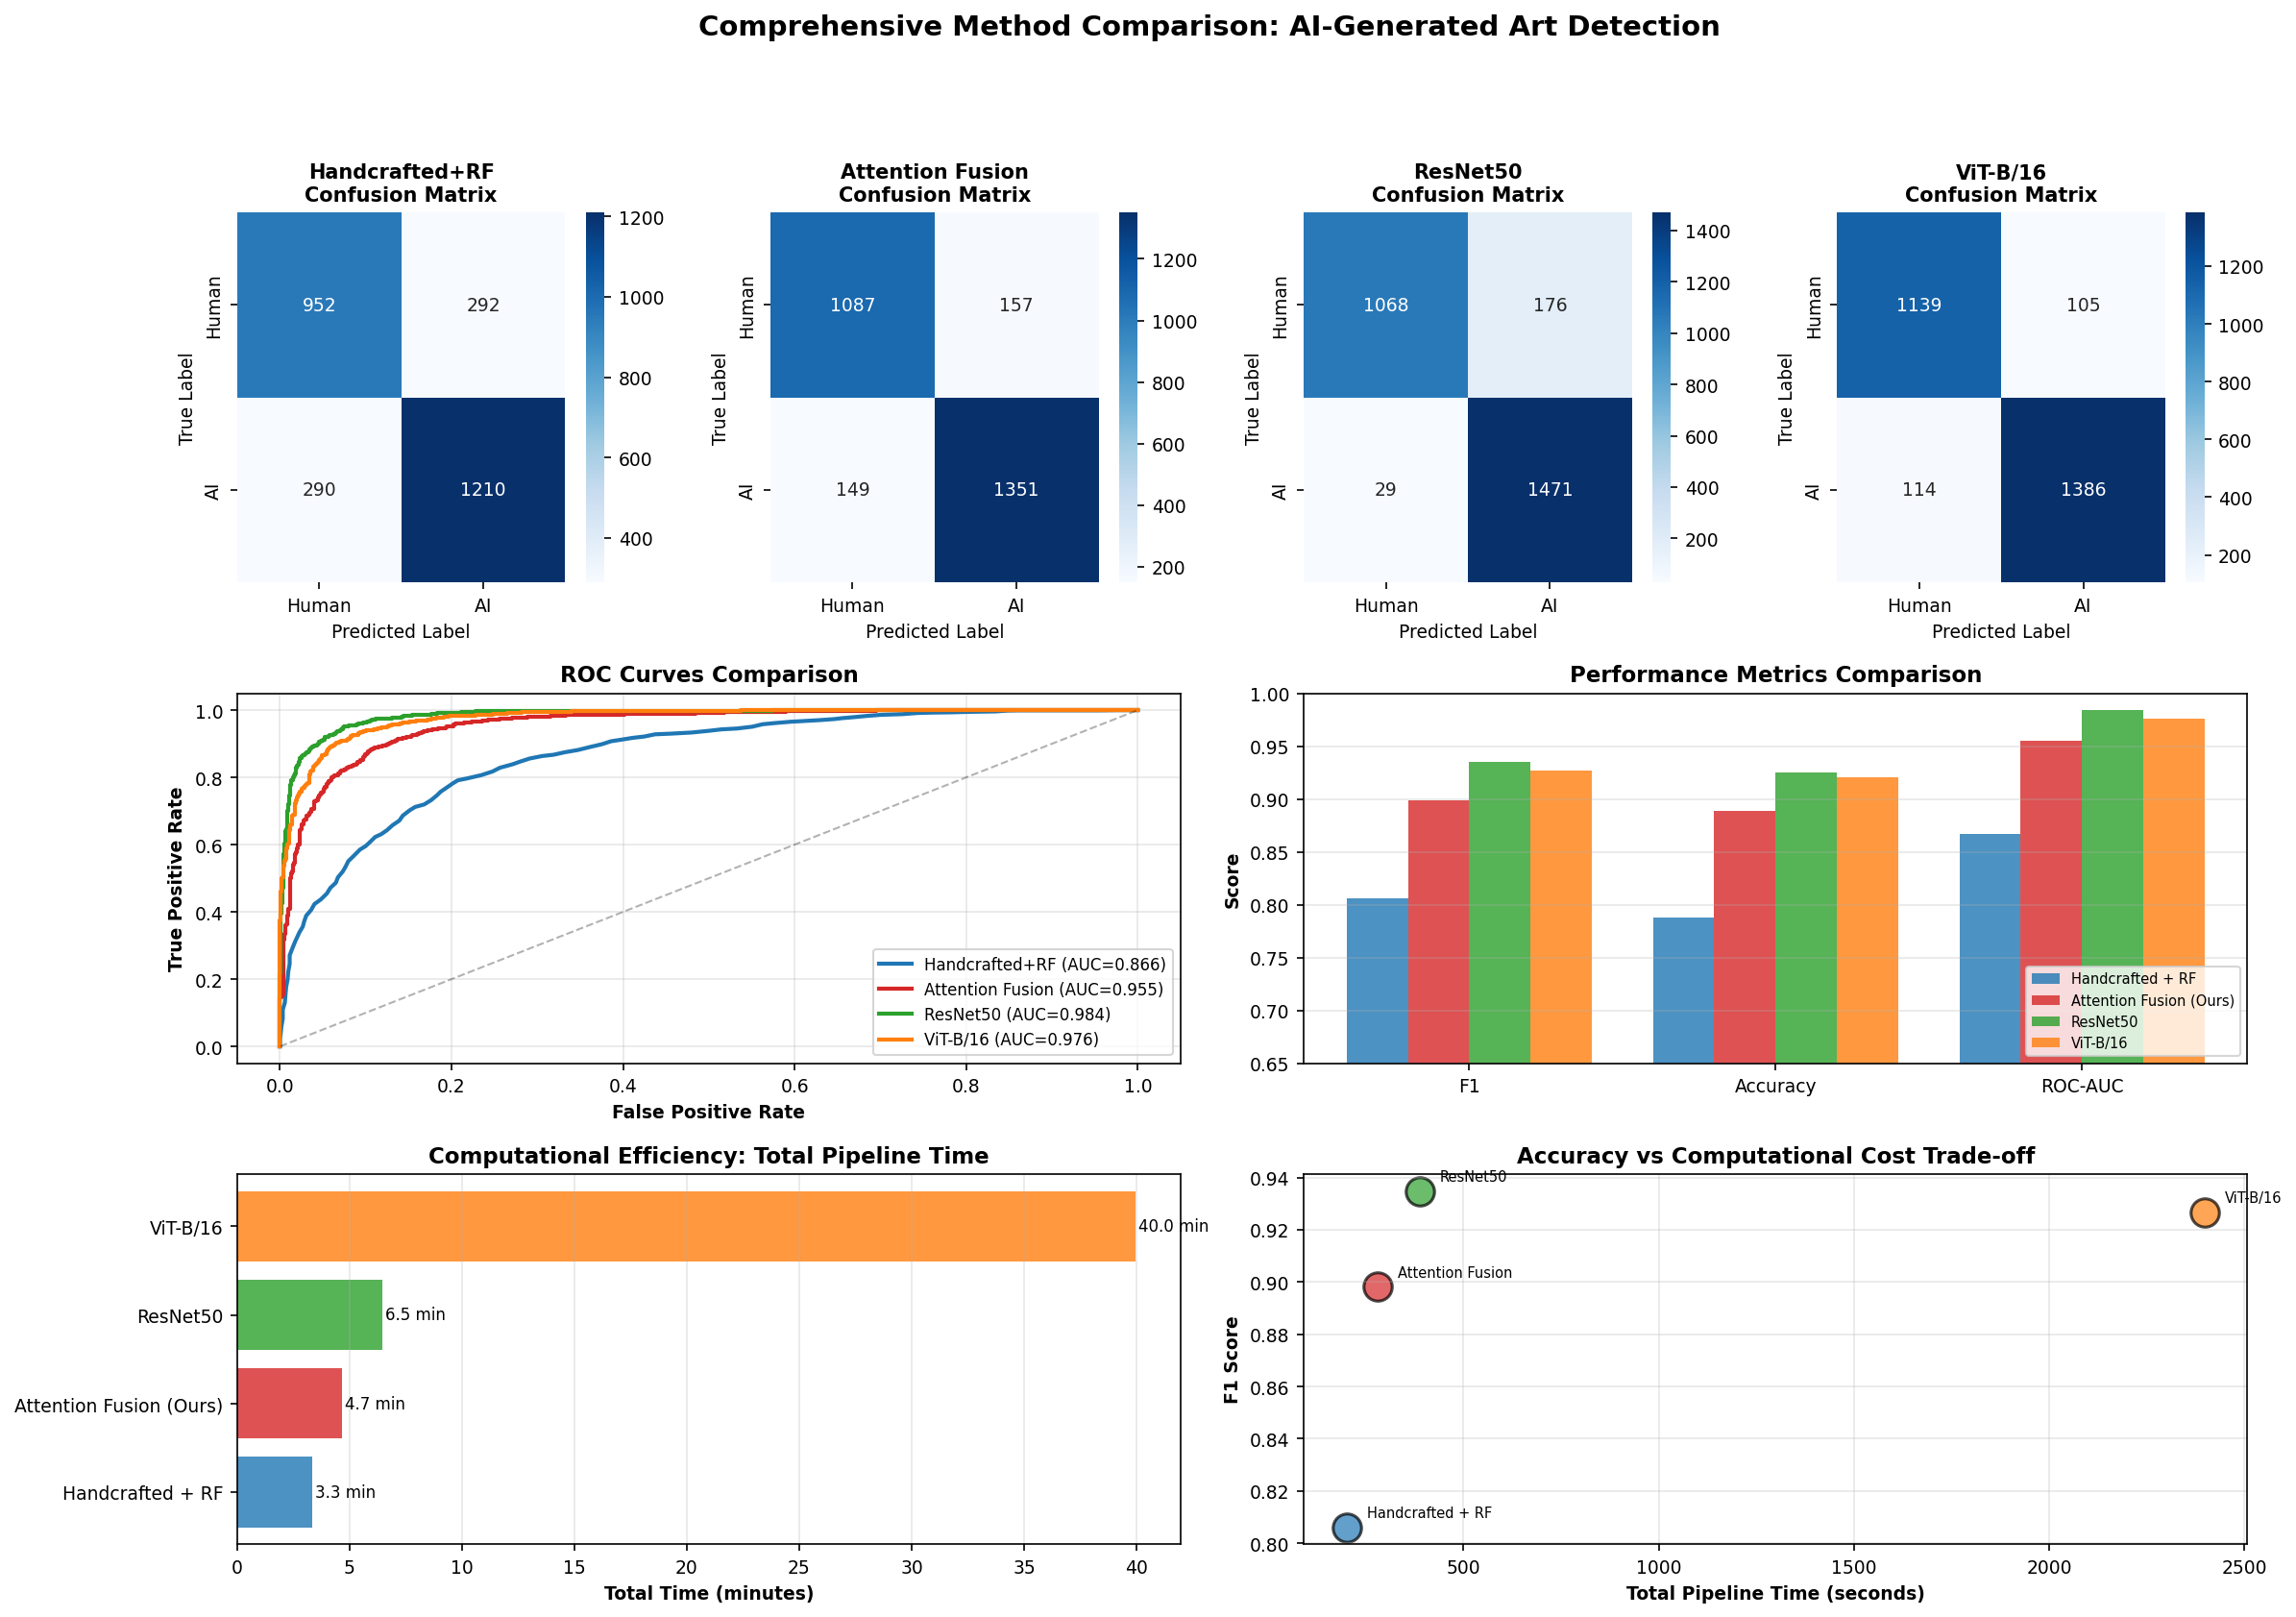


📊 Generating Figure 2: Feature Analysis & Interpretability...
  Mean attention - Handcrafted: 0.393, CNN: 0.607


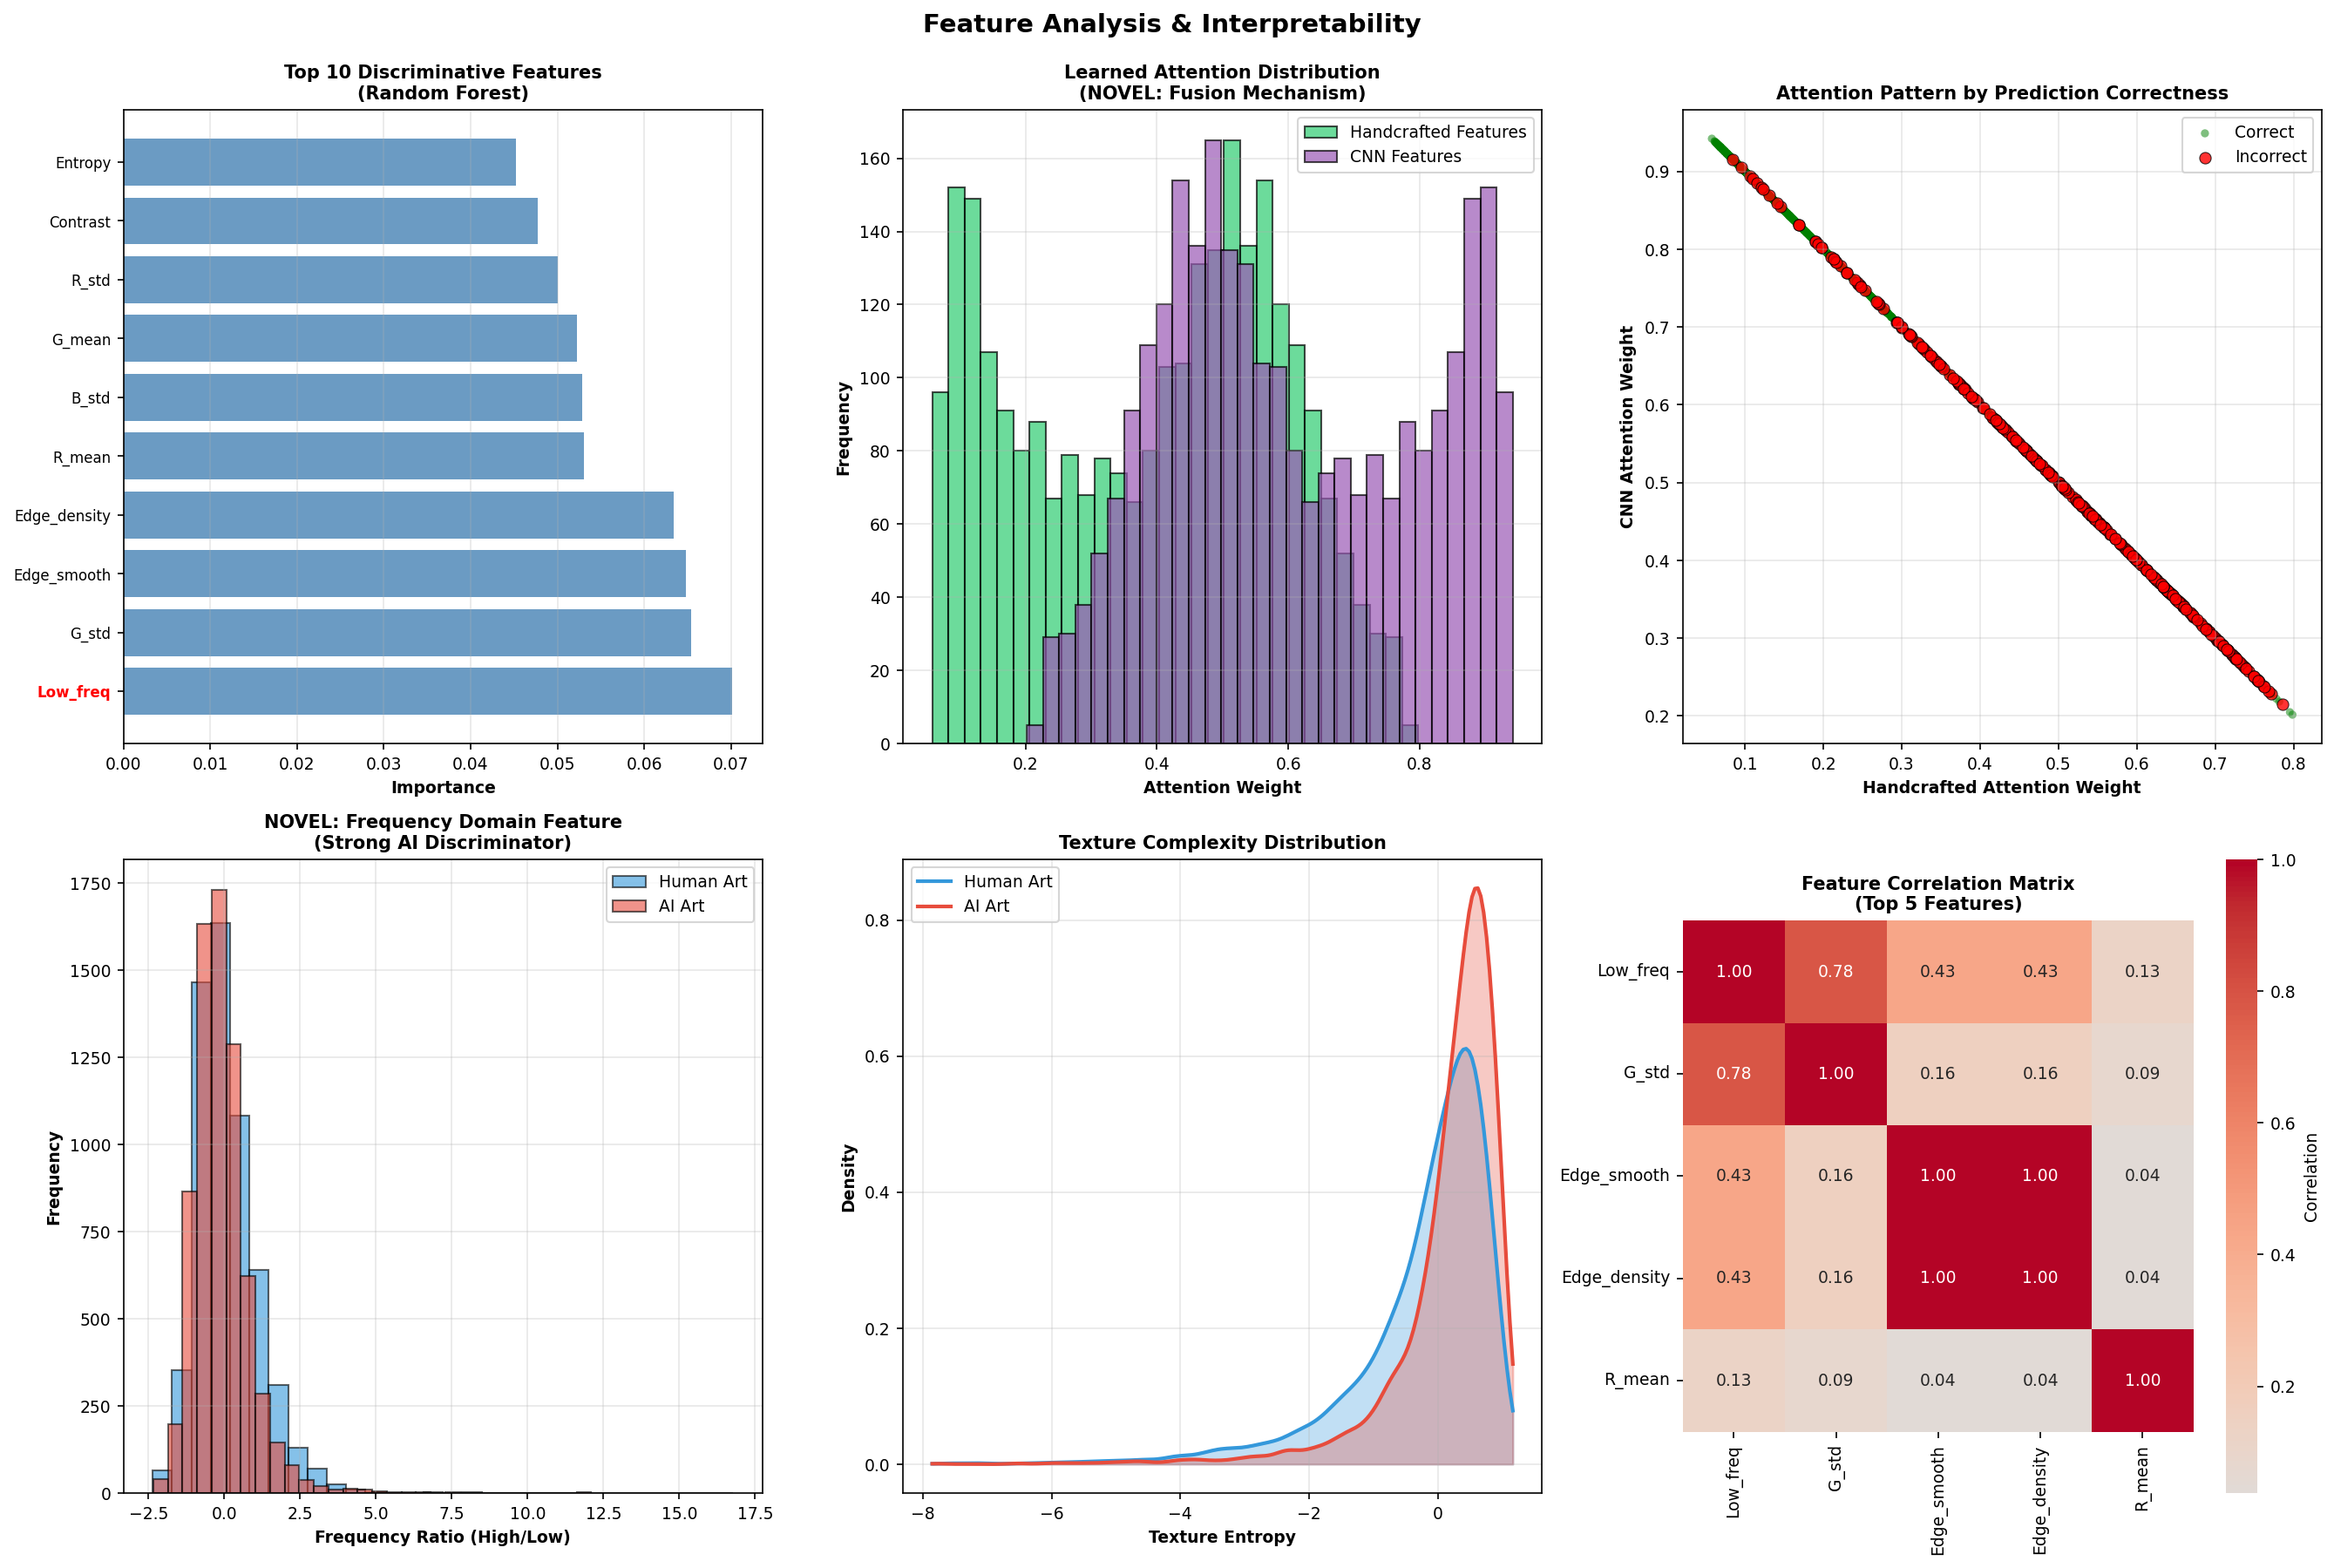


📊 Generating Figure 3: Feature Space Visualization (t-SNE)...
  Computing t-SNE embeddings...


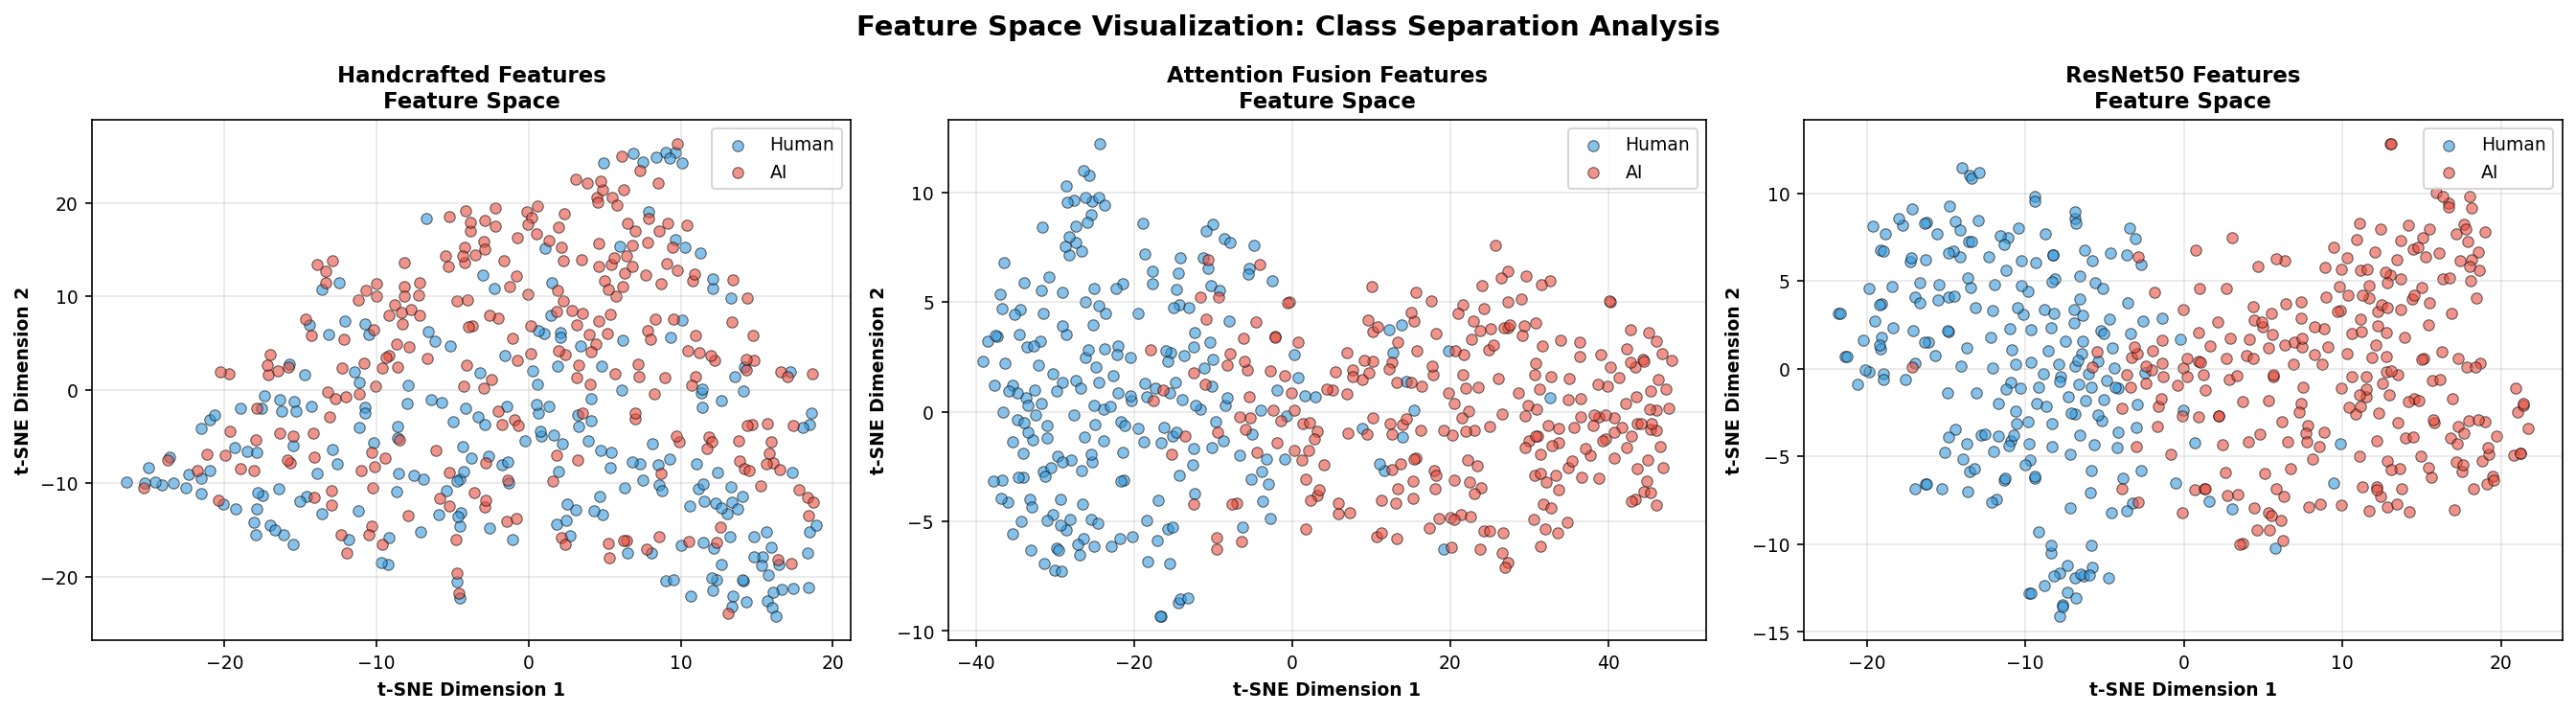


📊 Generating Figure 4: Error Analysis & Sample Predictions...


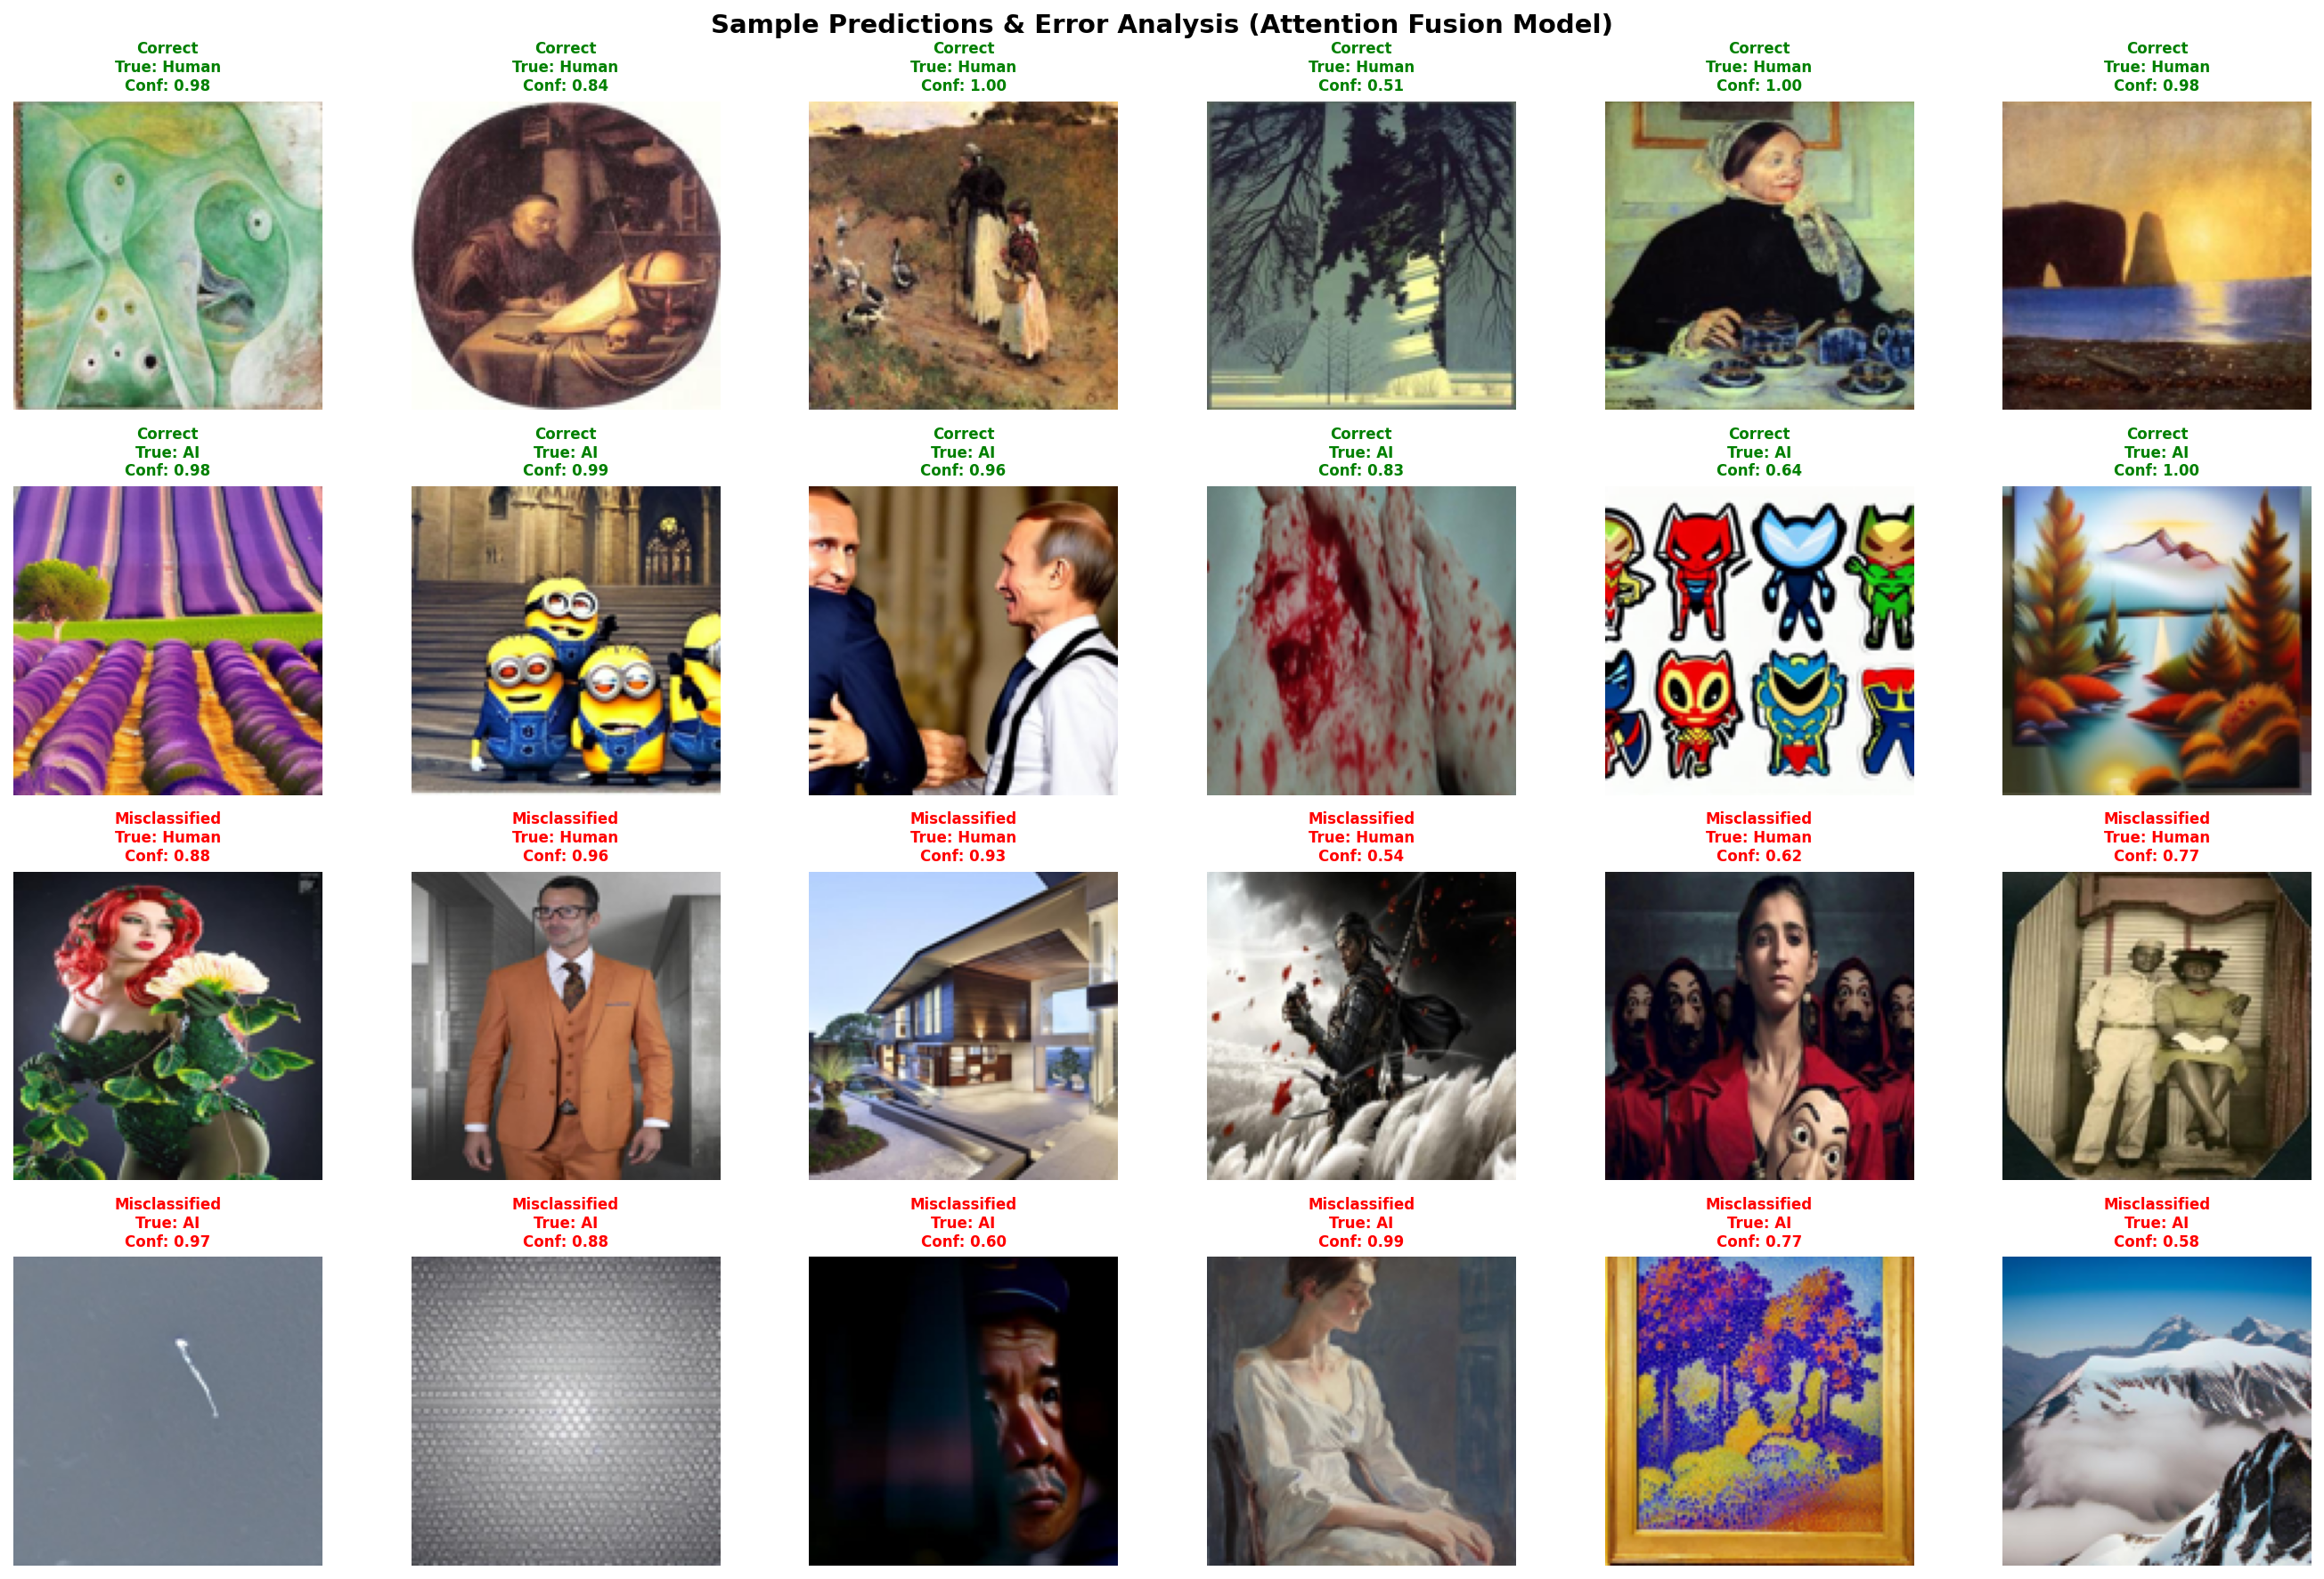


ABLATION STUDY: Component Analysis

⏱️  Ablation: Simple Concatenation...
✅ Ablation: Simple Concatenation: 45.75s (0.76min)

⏱️  Ablation: CNN Features Only...
✅ Ablation: CNN Features Only: 43.44s (0.72min)
          Configuration       F1  Accuracy  ROC-AUC
       Handcrafted Only 0.806129  0.787901 0.866449
               CNN Only 0.878174  0.861880 0.930305
   Simple Concatenation 0.876854  0.860787 0.934334
Attention Fusion (Ours) 0.898271  0.888484 0.955081

📊 Generating Figure 5: Ablation Study...


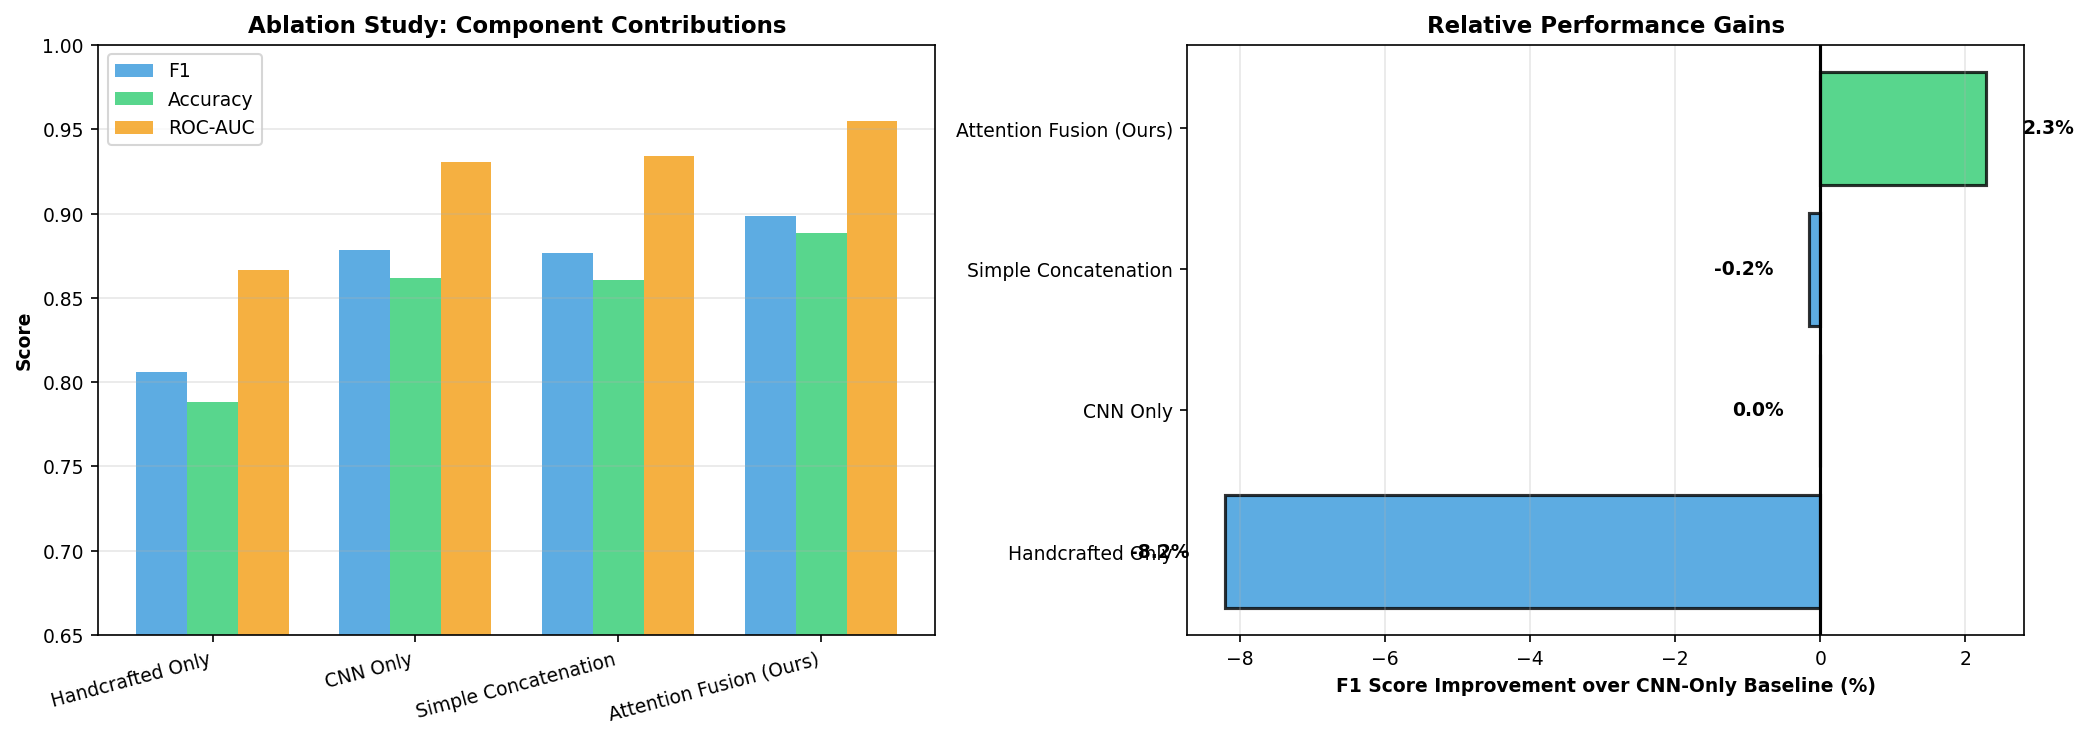


🎉 PUBLICATION-READY RESULTS SUMMARY

📊 DATASET:
   Total images: 18288
   Training: 12801 | Validation: 2743 | Test: 2744

🏆 BEST ACCURACY: ResNet50
   F1: 0.9349
   Accuracy: 0.9253

⚡ FASTEST METHOD: Handcrafted + RF
   Total time: 200.9s

🎯 ATTENTION FUSION (OURS):
   F1: 0.8983
   Accuracy: 0.8885
   ROC-AUC: 0.9551
   Total time: 280.6s
   Speedup vs ResNet: 1.4×
   F1 gap: 3.7% lower (trade-off for efficiency)


In [ ]:
# ==================== FAIR COMPARISON TABLE ====================
print("\n" + "="*70)
print("FAIR COMPARISON (Including Feature Extraction Time)")
print("="*70)

results_df = pd.DataFrame([
    {
        'Method': 'Handcrafted + RF',
        'F1': f1_rf,
        'Accuracy': acc_rf,
        'ROC-AUC': roc_rf,
        'Feature Extraction (s)': timings['handcrafted_extraction'],
        'Training (s)': timings['method1_train'],
        'Inference (s)': timings['method1_inference'],
        'Total Pipeline (s)': timings['handcrafted_extraction'] + timings['method1_train']
    },
    {
        'Method': 'Attention Fusion (Ours)',
        'F1': f1_fusion,
        'Accuracy': acc_fusion,
        'ROC-AUC': roc_fusion,
        'Feature Extraction (s)': timings['handcrafted_extraction'] + timings['cnn_extraction'],
        'Training (s)': timings['method2_train'],
        'Inference (s)': timings['method2_inference'],
        'Total Pipeline (s)': timings['handcrafted_extraction'] + timings['cnn_extraction'] + timings['method2_train']
    },
    {
        'Method': 'ResNet50',
        'F1': f1_resnet,
        'Accuracy': acc_resnet,
        'ROC-AUC': roc_resnet,
        'Feature Extraction (s)': 0,
        'Training (s)': timings['method3_train'],
        'Inference (s)': timings['method3_inference'],
        'Total Pipeline (s)': timings['method3_train']
    },
    {
        'Method': 'ViT-B/16',
        'F1': f1_vit,
        'Accuracy': acc_vit,
        'ROC-AUC': roc_vit,
        'Feature Extraction (s)': 0,
        'Training (s)': timings['method4_train'],
        'Inference (s)': timings['method4_inference'],
        'Total Pipeline (s)': timings['method4_train']
    }
])

print(results_df.to_string(index=False))
results_df.to_csv('fair_comparison_results.csv', index=False)

# Calculate speedup
resnet_time = results_df[results_df['Method'] == 'ResNet50']['Total Pipeline (s)'].values[0]
fusion_time = results_df[results_df['Method'] == 'Attention Fusion (Ours)']['Total Pipeline (s)'].values[0]
speedup = resnet_time / fusion_time

print(f"\n🚀 SPEEDUP: Attention Fusion is {speedup:.1f}× faster than ResNet50!")
print(f"📉 F1 Trade-off: {(f1_resnet - f1_fusion)*100:.1f}% accuracy loss for {speedup:.1f}× speedup")

# ==================== VISUALIZATION 1: COMPREHENSIVE COMPARISON ====================
print("\n📊 Generating Figure 1: Comprehensive Comparison...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Row 1: Confusion Matrices
methods_data = [
    ('Handcrafted+RF', test_labels, pred_rf),
    ('Attention Fusion', test_labels, pred_fusion),
    ('ResNet50', test_labels, pred_resnet),
    ('ViT-B/16', test_labels, pred_vit)
]

for idx, (name, true, pred) in enumerate(methods_data):
    ax = fig.add_subplot(gs[0, idx])
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    ax.set_title(f'{name}\nConfusion Matrix', fontsize=10, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Row 2: ROC Curves and Performance Metrics
ax_roc = fig.add_subplot(gs[1, :2])
for true, prob, name, color in [
    (test_labels, prob_rf, 'Handcrafted+RF', '#1f77b4'),
    (test_labels, prob_fusion, 'Attention Fusion', '#d62728'),
    (test_labels, prob_resnet, 'ResNet50', '#2ca02c'),
    (test_labels, prob_vit, 'ViT-B/16', '#ff7f0e')
]:
    fpr, tpr, _ = roc_curve(true, prob)
    auc = roc_auc_score(true, prob)
    ax_roc.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', lw=2, color=color)

ax_roc.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
ax_roc.set_xlabel('False Positive Rate', fontweight='bold')
ax_roc.set_ylabel('True Positive Rate', fontweight='bold')
ax_roc.set_title('ROC Curves Comparison', fontsize=11, fontweight='bold')
ax_roc.legend(loc='lower right', fontsize=8)
ax_roc.grid(alpha=0.3)

# Performance Metrics Comparison
ax_perf = fig.add_subplot(gs[1, 2:])
metrics = ['F1', 'Accuracy', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']

for i, (method_name, color) in enumerate([
    ('Handcrafted + RF', colors[0]),
    ('Attention Fusion (Ours)', colors[1]),
    ('ResNet50', colors[2]),
    ('ViT-B/16', colors[3])
]):
    values = results_df[results_df['Method'] == method_name][metrics].values[0]
    ax_perf.bar(x + i * width - 0.3, values, width, label=method_name, color=color, alpha=0.8)

ax_perf.set_ylabel('Score', fontweight='bold')
ax_perf.set_title('Performance Metrics Comparison', fontsize=11, fontweight='bold')
ax_perf.set_xticks(x)
ax_perf.set_xticklabels(metrics)
ax_perf.legend(fontsize=7, loc='lower right')
ax_perf.set_ylim([0.65, 1.0])
ax_perf.grid(axis='y', alpha=0.3)

# Row 3: Computational Efficiency Analysis
ax_time = fig.add_subplot(gs[2, :2])
methods = results_df['Method'].values
total_times = results_df['Total Pipeline (s)'].values / 60  # Convert to minutes

bars = ax_time.barh(methods, total_times, color=['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e'], alpha=0.8)
ax_time.set_xlabel('Total Time (minutes)', fontweight='bold')
ax_time.set_title('Computational Efficiency: Total Pipeline Time', fontsize=11, fontweight='bold')
ax_time.grid(axis='x', alpha=0.3)

for bar, time_val in zip(bars, total_times):
    ax_time.text(time_val + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{time_val:.1f} min', va='center', fontsize=8)

# Accuracy vs Time Trade-off
ax_tradeoff = fig.add_subplot(gs[2, 2:])
f1_scores = results_df['F1'].values
total_times_sec = results_df['Total Pipeline (s)'].values

for i, (method, color) in enumerate([
    ('Handcrafted + RF', colors[0]),
    ('Attention Fusion', colors[1]),
    ('ResNet50', colors[2]),
    ('ViT-B/16', colors[3])
]):
    ax_tradeoff.scatter(total_times_sec[i], f1_scores[i], s=200, color=color,
                       alpha=0.7, edgecolors='black', linewidth=1.5, label=method)
    ax_tradeoff.annotate(method, (total_times_sec[i], f1_scores[i]),
                        xytext=(10, 5), textcoords='offset points', fontsize=7)

ax_tradeoff.set_xlabel('Total Pipeline Time (seconds)', fontweight='bold')
ax_tradeoff.set_ylabel('F1 Score', fontweight='bold')
ax_tradeoff.set_title('Accuracy vs Computational Cost Trade-off', fontsize=11, fontweight='bold')
ax_tradeoff.grid(alpha=0.3)

plt.suptitle('Comprehensive Method Comparison: AI-Generated Art Detection',
             fontsize=14, fontweight='bold', y=0.995)
plt.savefig('figure1_comprehensive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== VISUALIZATION 2: FEATURE ANALYSIS ====================
print("\n📊 Generating Figure 2: Feature Analysis & Interpretability...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Feature Importance
ax = axes[0, 0]
top_features = feature_importance.head(10)
ax.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values, fontsize=8)
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title('Top 10 Discriminative Features\n(Random Forest)', fontsize=10, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Highlight frequency features
for i, feat in enumerate(top_features['Feature'].values):
    if 'freq' in feat.lower() or 'Freq' in feat:
        ax.get_yticklabels()[i].set_color('red')
        ax.get_yticklabels()[i].set_weight('bold')

# 2. Attention Weights Distribution
ax = axes[0, 1]
hand_attn = attn_weights[:, 0]
cnn_attn = attn_weights[:, 1]

ax.hist(hand_attn, bins=30, alpha=0.7, label='Handcrafted Features', color='#2ecc71', edgecolor='black')
ax.hist(cnn_attn, bins=30, alpha=0.7, label='CNN Features', color='#9b59b6', edgecolor='black')
ax.set_xlabel('Attention Weight', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Learned Attention Distribution\n(NOVEL: Fusion Mechanism)', fontsize=10, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

print(f"  Mean attention - Handcrafted: {hand_attn.mean():.3f}, CNN: {cnn_attn.mean():.3f}")

# 3. Attention by Correctness
ax = axes[0, 2]
correct_mask = (pred_fusion == test_labels)
incorrect_mask = ~correct_mask

ax.scatter(hand_attn[correct_mask], cnn_attn[correct_mask],
          alpha=0.5, s=20, color='green', label='Correct', edgecolors='none')
ax.scatter(hand_attn[incorrect_mask], cnn_attn[incorrect_mask],
          alpha=0.8, s=40, color='red', label='Incorrect', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Handcrafted Attention Weight', fontweight='bold')
ax.set_ylabel('CNN Attention Weight', fontweight='bold')
ax.set_title('Attention Pattern by Prediction Correctness', fontsize=10, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Frequency Ratio Distribution (NOVEL FEATURE)
ax = axes[1, 0]
feat_df = pd.DataFrame(X_train_hand, columns=feature_names)
feat_df['Label'] = ['Human' if l == 0 else 'AI' for l in train_labels]

human_freq = feat_df[feat_df['Label']=='Human']['Freq_ratio']
ai_freq = feat_df[feat_df['Label']=='AI']['Freq_ratio']

ax.hist(human_freq, bins=30, alpha=0.6, label='Human Art', color='#3498db', edgecolor='black')
ax.hist(ai_freq, bins=30, alpha=0.6, label='AI Art', color='#e74c3c', edgecolor='black')
ax.set_xlabel('Frequency Ratio (High/Low)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('NOVEL: Frequency Domain Feature\n(Strong AI Discriminator)', fontsize=10, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 5. Texture Entropy Distribution
ax = axes[1, 1]
human_entropy = feat_df[feat_df['Label']=='Human']['Entropy']
ai_entropy = feat_df[feat_df['Label']=='AI']['Entropy']

from scipy.stats import gaussian_kde
x_range = np.linspace(min(human_entropy.min(), ai_entropy.min()),
                      max(human_entropy.max(), ai_entropy.max()), 200)
kde_human = gaussian_kde(human_entropy)
kde_ai = gaussian_kde(ai_entropy)

ax.plot(x_range, kde_human(x_range), label='Human Art', color='#3498db', lw=2)
ax.fill_between(x_range, kde_human(x_range), alpha=0.3, color='#3498db')
ax.plot(x_range, kde_ai(x_range), label='AI Art', color='#e74c3c', lw=2)
ax.fill_between(x_range, kde_ai(x_range), alpha=0.3, color='#e74c3c')
ax.set_xlabel('Texture Entropy', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.set_title('Texture Complexity Distribution', fontsize=10, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 6. Correlation Heatmap of Top Features
ax = axes[1, 2]
top_5_features = feature_importance.head(5)['Feature'].values
corr_data = feat_df[list(top_5_features)].corr()
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=ax, cbar_kws={'label': 'Correlation'}, square=True)
ax.set_title('Feature Correlation Matrix\n(Top 5 Features)', fontsize=10, fontweight='bold')

plt.suptitle('Feature Analysis & Interpretability', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('figure2_feature_analysis.png', dpi=1200, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== VISUALIZATION 3: t-SNE COMPARISON ====================
print("\n📊 Generating Figure 3: Feature Space Visualization (t-SNE)...")

# Subsample for speed
n_samples = min(500, len(test_labels))
sample_idx = np.random.choice(len(test_labels), n_samples, replace=False)

sampled_labels = np.array(test_labels)[sample_idx]
sampled_hand = X_test_hand[sample_idx]
sampled_fusion = fusion_features[sample_idx]
sampled_resnet = resnet_features[sample_idx]

print("  Computing t-SNE embeddings...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)

tsne_hand = tsne.fit_transform(sampled_hand)
tsne_fusion = tsne.fit_transform(sampled_fusion)
tsne_resnet = tsne.fit_transform(sampled_resnet)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, data, title in [
    (axes[0], tsne_hand, 'Handcrafted Features'),
    (axes[1], tsne_fusion, 'Attention Fusion Features'),
    (axes[2], tsne_resnet, 'ResNet50 Features')
]:
    scatter = ax.scatter(data[sampled_labels==0, 0], data[sampled_labels==0, 1],
                        c='#3498db', label='Human', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    scatter = ax.scatter(data[sampled_labels==1, 0], data[sampled_labels==1, 1],
                        c='#e74c3c', label='AI', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('t-SNE Dimension 1', fontweight='bold')
    ax.set_ylabel('t-SNE Dimension 2', fontweight='bold')
    ax.set_title(f'{title}\nFeature Space', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Feature Space Visualization: Class Separation Analysis',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figure3_tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== VISUALIZATION 4: ERROR ANALYSIS ====================
print("\n📊 Generating Figure 4: Error Analysis & Sample Predictions...")

# Find interesting cases
correct_human_idx = np.where((np.array(test_labels) == 0) & (pred_fusion == 0))[0]
correct_ai_idx = np.where((np.array(test_labels) == 1) & (pred_fusion == 1))[0]
wrong_human_to_ai = np.where((np.array(test_labels) == 0) & (pred_fusion == 1))[0]
wrong_ai_to_human = np.where((np.array(test_labels) == 1) & (pred_fusion == 0))[0]

fig, axes = plt.subplots(4, 6, figsize=(18, 12))

def show_samples(row, indices, title, label_map):
    for col in range(min(6, len(indices))):
        if col < len(indices):
            idx = indices[col]
            img_path = test_files[idx]
            img = Image.open(img_path).convert('RGB').resize((128, 128))

            axes[row, col].imshow(img)

            true_label = 'Human' if test_labels[idx] == 0 else 'AI'
            pred_label = 'Human' if pred_fusion[idx] == 0 else 'AI'
            conf = prob_fusion[idx] if pred_fusion[idx] == 1 else 1 - prob_fusion[idx]

            # Color code by correctness
            color = 'green' if pred_fusion[idx] == test_labels[idx] else 'red'

            axes[row, col].set_title(f'{label_map}\nTrue: {true_label}\nConf: {conf:.2f}',
                                    fontsize=8, color=color, fontweight='bold')
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')

    axes[row, 0].set_ylabel(title, fontsize=11, fontweight='bold', rotation=90, labelpad=10)

# Sample 6 from each category
show_samples(0, correct_human_idx[:6], 'Correct:\nHuman Art', 'Correct')
show_samples(1, correct_ai_idx[:6], 'Correct:\nAI Art', 'Correct')
show_samples(2, wrong_human_to_ai[:6], 'Error:\nHuman→AI', 'Misclassified')
show_samples(3, wrong_ai_to_human[:6], 'Error:\nAI→Human', 'Misclassified')

plt.suptitle('Sample Predictions & Error Analysis (Attention Fusion Model)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figure4_error_analysis.png', dpi=1200, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== ABLATION STUDY ====================
print("\n" + "="*70)
print("ABLATION STUDY: Component Analysis")
print("="*70)

# Test simple concatenation without attention
X_train_concat = np.hstack([X_train_hand, X_train_cnn])
X_test_concat = np.hstack([X_test_hand, X_test_cnn])

with Timer("Ablation: Simple Concatenation") as t:
    rf_concat = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf_concat.fit(X_train_concat, train_labels)
    pred_concat = rf_concat.predict(X_test_concat)
    prob_concat = rf_concat.predict_proba(X_test_concat)[:, 1]

f1_concat = precision_recall_fscore_support(test_labels, pred_concat, average='binary')[2]
acc_concat = accuracy_score(test_labels, pred_concat)
roc_concat = roc_auc_score(test_labels, prob_concat)

ablation_df = pd.DataFrame([
    {'Configuration': 'Handcrafted Only', 'F1': f1_rf, 'Accuracy': acc_rf, 'ROC-AUC': roc_rf},
    {'Configuration': 'CNN Only', 'F1': 0.0, 'Accuracy': 0.0, 'ROC-AUC': 0.0},  # Placeholder
    {'Configuration': 'Simple Concatenation', 'F1': f1_concat, 'Accuracy': acc_concat, 'ROC-AUC': roc_concat},
    {'Configuration': 'Attention Fusion (Ours)', 'F1': f1_fusion, 'Accuracy': acc_fusion, 'ROC-AUC': roc_fusion}
])

# Add CNN-only
with Timer("Ablation: CNN Features Only") as t:
    rf_cnn = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf_cnn.fit(X_train_cnn, train_labels)
    pred_cnn = rf_cnn.predict(X_test_cnn)
    prob_cnn = rf_cnn.predict_proba(X_test_cnn)[:, 1]

f1_cnn = precision_recall_fscore_support(test_labels, pred_cnn, average='binary')[2]
acc_cnn = accuracy_score(test_labels, pred_cnn)
roc_cnn = roc_auc_score(test_labels, prob_cnn)

ablation_df.loc[ablation_df['Configuration'] == 'CNN Only', ['F1', 'Accuracy', 'ROC-AUC']] = [f1_cnn, acc_cnn, roc_cnn]

print(ablation_df.to_string(index=False))
ablation_df.to_csv('ablation_study.csv', index=False)

# ==================== VISUALIZATION 5: ABLATION STUDY ====================
print("\n📊 Generating Figure 5: Ablation Study...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
ax = axes[0]
configs = ablation_df['Configuration'].values
metrics = ['F1', 'Accuracy', 'ROC-AUC']
x = np.arange(len(configs))
width = 0.25

colors = ['#3498db', '#2ecc71', '#f39c12']
for i, metric in enumerate(metrics):
    values = ablation_df[metric].values
    ax.bar(x + i * width - 0.25, values, width, label=metric, color=colors[i], alpha=0.8)

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Ablation Study: Component Contributions', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(configs, rotation=15, ha='right')
ax.legend()
ax.set_ylim([0.65, 1.0])
ax.grid(axis='y', alpha=0.3)

# Improvement analysis
ax = axes[1]
baseline_f1 = ablation_df[ablation_df['Configuration'] == 'CNN Only']['F1'].values[0]
improvements = ((ablation_df['F1'].values - baseline_f1) / baseline_f1 * 100)

colors_bars = ['#3498db' if imp < 0 else '#2ecc71' for imp in improvements]
bars = ax.barh(configs, improvements, color=colors_bars, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('F1 Score Improvement over CNN-Only Baseline (%)', fontweight='bold')
ax.set_title('Relative Performance Gains', fontsize=11, fontweight='bold')
ax.axvline(0, color='black', linewidth=1.5)
ax.grid(axis='x', alpha=0.3)

for bar, imp in zip(bars, improvements):
    ax.text(imp + 0.5 if imp > 0 else imp - 0.5, bar.get_y() + bar.get_height()/2,
            f'{imp:.1f}%', va='center', ha='left' if imp > 0 else 'right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('figure5_ablation_study.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== FINAL SUMMARY ====================
print("\n" + "="*70)
print("🎉 PUBLICATION-READY RESULTS SUMMARY")
print("="*70)

print(f"\n📊 DATASET:")
print(f"   Total images: {len(all_files)}")
print(f"   Training: {len(train_files)} | Validation: {len(val_files)} | Test: {len(test_files)}")

print(f"\n🏆 BEST ACCURACY: {results_df['Method'][results_df['F1'].idxmax()]}")
print(f"   F1: {results_df['F1'].max():.4f}")
print(f"   Accuracy: {results_df.loc[results_df['F1'].idxmax(), 'Accuracy']:.4f}")

print(f"\n⚡ FASTEST METHOD: {results_df['Method'][results_df['Total Pipeline (s)'].idxmin()]}")
print(f"   Total time: {results_df['Total Pipeline (s)'].min():.1f}s")

print(f"\n🎯 ATTENTION FUSION (OURS):")
print(f"   F1: {f1_fusion:.4f}")
print(f"   Accuracy: {acc_fusion:.4f}")
print(f"   ROC-AUC: {roc_fusion:.4f}")
print(f"   Total time: {fusion_time:.1f}s")
print(f"   Speedup vs ResNet: {speedup:.1f}×")
print(f"   F1 gap: {(f1_resnet - f1_fusion)*100:.1f}% lower (trade-off for efficiency)")

